In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage

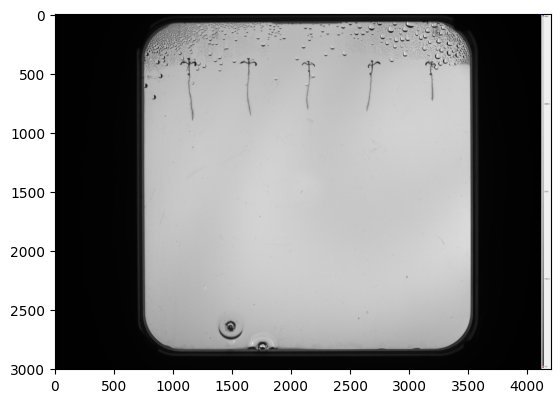

In [2]:
# Load image 1
img_path_1 = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task3/task_3_image_1.png'
img1 = cv2.imread(img_path_1)
plt.imshow(img1, cmap='gray')

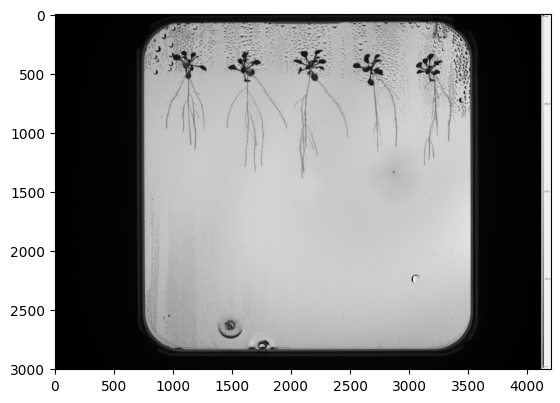

In [3]:
# Load image 2
img_path_2 = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task3/task_3_image_2.png'
img2 = cv2.imread(img_path_2)
plt.imshow(img2, cmap='gray')

In [4]:
def cropped_petri_dish(img):

    # Finding threshold to isolate the region of interest
    _, output = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 50, 60, cv2.THRESH_BINARY)

    # Removing noise from the image
    output = cv2.medianBlur(output, 15)
    kernel = np.ones((9, 9), dtype="uint8")
    output = cv2.erode(output, kernel, iterations=2)
    output = cv2.dilate(output, kernel, iterations=2)

    # Finding components
    _, _, stats, _ = cv2.connectedComponentsWithStats(output)

    # filtering the statistics to get the right object
    # limitations on x: discard the background and other artifacts
    # limitations on w/h (width/height): discard small objects
    df = pd.DataFrame(stats, columns=['x', 'y', 'w', 'h', 'area']).sort_values('area', ascending=False)
    df = df[df['x'] > 0]
    df = df[df['x'] < 4000]
    df = df[df['h'] > 1000]
    df = df[df['w'] > 1000]

    # get the statistics for the filtered object
    x, y, w, h, _ = np.array(df.head(1))[0]

    # crop the image
    im_cropped = img[y:y + min(w, h), x:x + min(w, h)]

    # get the x, y coordinates of the cropped image as well as the width/height
    dims = {'x': x, 'y': y, 'size': min(w, h)}
    
    return im_cropped, dims

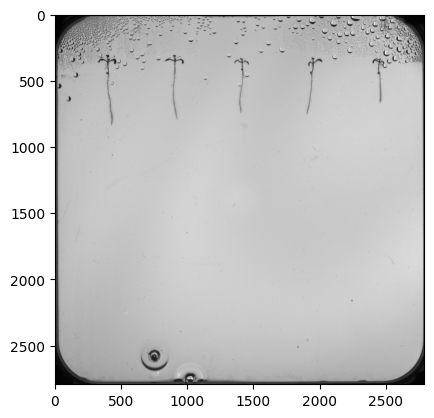

In [5]:
# Crop and plot image 1
img1, _ = cropped_petri_dish(img1)
plt.imshow(img1, cmap='gray')

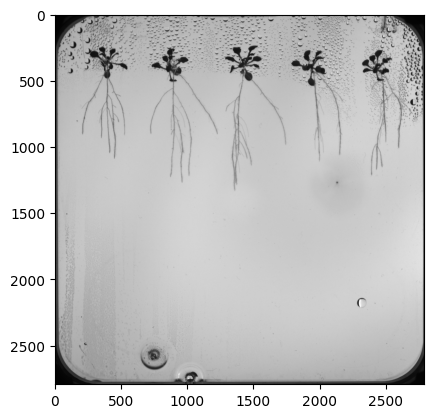

In [6]:
# Crop and plot image 2
img2, _ = cropped_petri_dish(img2)
plt.imshow(img2, cmap='gray')

In [7]:
# Segment large objects 
def segment_instances(img):

    # Threshold the image (inverse binary) so that the objects are white and the background is black
    _, img = cv2.threshold(img, 166, 255, cv2.THRESH_BINARY_INV)
    # Ensure we have a single-channel grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Label each connected component; background is label 0
    _, labels = cv2.connectedComponents(img)
    # Remove connected components (objects) smaller than 2000 pixels
    removed = skimage.morphology.remove_small_objects(labels, min_size=2000)
    # Mask out everything from row index 2000 to the bottom of the image
    removed[2000:, :] = 0

    return removed

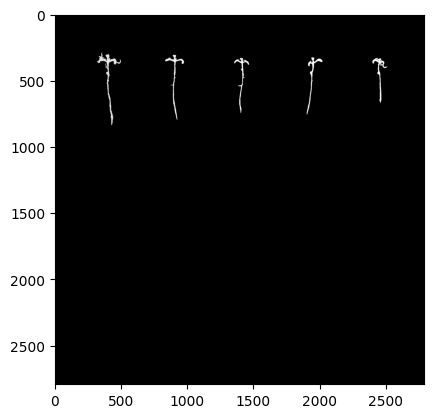

In [8]:
# Segment and plot image 1
segmented_img_1 = segment_instances(img1)
plt.imshow(segmented_img_1, cmap='gray')

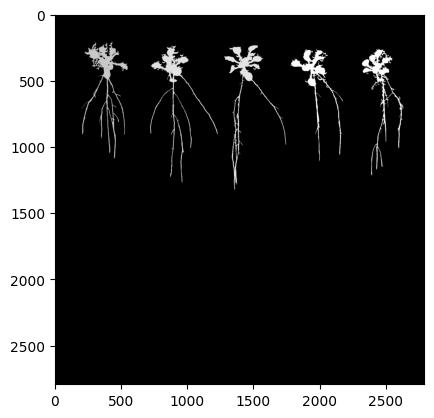

In [9]:
# Segment and plot image 2
segmented_img_2 = segment_instances(img2)
plt.imshow(segmented_img_2, cmap='gray')

In [10]:
# Function to place the segmented image back into an image of the original size
def restore_full_mask(segmentation_img, original_size):
    # Fill the blank canvas
    background_color = segmentation_img[0, 0]
    # Create a blank image of the original size, filled with the chosen background colour
    img = np.full(original_size, background_color, dtype=np.uint8)
    # Copy the segmentation mask into the upper-left corner of the blank canvas
    img[:segmentation_img.shape[0], :segmentation_img.shape[1]] = segmentation_img
    return segmentation_img

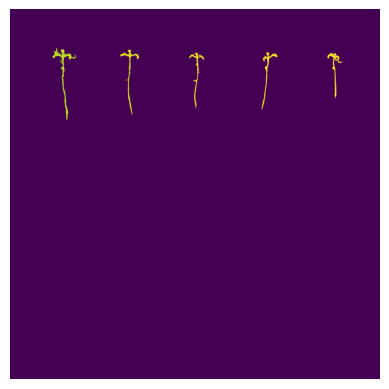

In [11]:
# Get the original size of image 1
original_size = segmented_img_1.shape
# function to create the new image
final_img_1 = restore_full_mask(segmented_img_1, original_size)
plt.imshow(final_img_1)
plt.axis('off')
plt.show()

In [ ]:
np.uniqe

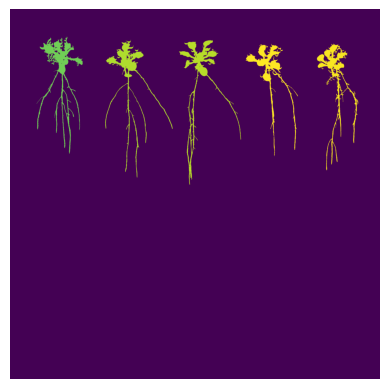

In [12]:
original_size = segmented_img_2.shape
# function to create the new image
final_img_2 = restore_full_mask(segmented_img_2, original_size)
plt.imshow(final_img_2)
plt.axis('off')
plt.show()